In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Write Data Workfolw

# Data

In [2]:
data = pd.read_csv('full_data_labeled.csv')
data = data.drop(columns=['CI SCORE GLOVE','CI SCORE GLOVE 2','CI SCORE GLOVE 50','CI MEAN SCORES']).replace(np.nan,'None')
data.shape

(61698, 14)

In [18]:
data['Label'].value_counts()

Label
yes    51386
no     10312
Name: count, dtype: int64

# Preparation Features and Label

In [4]:
df = data.copy()
df['LabelEncoded'] = df['Label'].replace(['no','yes'],[0,1])
df = df.drop(columns=['Kmeans_clusters','CI SCORE','Label'])
df.head(3)

,index,Vulnerability Type(s),Vulnerability Name,Access,Complexity,Authentication,Conf.,Integ.,Avail,Score,Number Of Related Vulnerabilities,LabelEncoded
0,1,XSS,Failure to Preserve Web Page Structure ('Cross...,Remote,Medium,Not required,None,Partial,None,4.3,22413.0,0
1,2,Unknown,Improper Authentication,Remote,Low,Not required,Partial,Partial,Partial,7.5,3011.0,1
2,3,Unknown,URL Redirection to Untrusted Site ('Open Redir...,Remote,Medium,Not required,Partial,Partial,None,5.8,754.0,1


In [5]:
df.columns

Index(['index', 'Vulnerability Type(s)', 'Vulnerability Name', 'Access',
       'Complexity', 'Authentication', 'Conf.', 'Integ.', 'Avail', 'Score',
       'Number Of Related Vulnerabilities', 'LabelEncoded'],
      dtype='object')

In [6]:
for col in df.columns:
    print(df[col].nunique(),'\t',col)

61698 	 index
136 	 Vulnerability Type(s)
261 	 Vulnerability Name
4 	 Access
4 	 Complexity
3 	 Authentication
4 	 Conf.
4 	 Integ.
4 	 Avail
62 	 Score
122 	 Number Of Related Vulnerabilities
2 	 LabelEncoded


# OHE

In [7]:
numerical_cols = ['Score','Number Of Related Vulnerabilities']

categorical_cols = ['Vulnerability Type(s)', 'Vulnerability Name', 'Access',
                    'Complexity', 'Authentication', 'Conf.', 'Integ.', 'Avail']
label = ['LabelEncoded']


ohe = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    df[numerical_cols]
],axis=1)



# OHE StandardScaler

In [8]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler = std_scaler.fit_transform(df[numerical_cols])

ohe_std_scaled = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    pd.DataFrame(std_scaler,columns=numerical_cols)
],axis=1)



# OHE MinMaxScaler

In [9]:
from sklearn.preprocessing import MinMaxScaler 

mn_scaler = MinMaxScaler()
mn_scaler = mn_scaler.fit_transform(df[numerical_cols])

ohe_mn_scaled = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    pd.DataFrame(mn_scaler,columns=numerical_cols)
],axis=1)



## Train Test Split

In [19]:
from sklearn.model_selection import train_test_split

x = ohe
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49358, 422), (12340, 422), (49358, 1), (12340, 1))

In [20]:
df[label].value_counts()

LabelEncoded
1               51386
0               10312
Name: count, dtype: int64

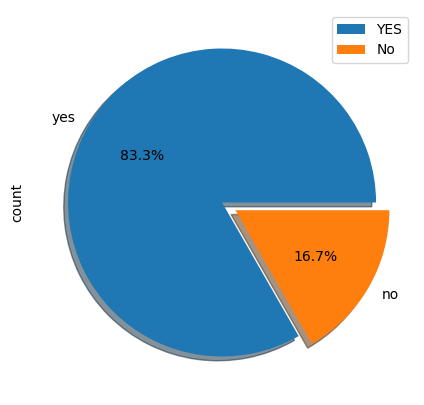

Label
yes    51386
no     10312
Name: count, dtype: int64


In [21]:
def show_loan_distrib(data,y):
    count = ""
    if isinstance(data, pd.DataFrame):
        count = data[y].value_counts()
    else:
        count = data.value_counts()

    count.plot(kind = 'pie', explode = [0, 0.1], 
               figsize = (5, 5), autopct = '%1.1f%%', shadow = True)
#     plt.ylabel("Loan: Fully Paid Vs. Not Fully Paid")
    plt.legend(["YES", "No"])
    plt.show()
    print(data[y].value_counts())
    


# Visualize the proportion of borrowers
show_loan_distrib(data,'Label')

# Model 

### without scaling

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

x = ohe
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=5)


logireg = LogisticRegression()
logireg.fit(X_train,y_train)

y_pred = logireg.predict(X_test)

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2041
           1       1.00      1.00      1.00     10299

    accuracy                           1.00     12340
   macro avg       1.00      1.00      1.00     12340
weighted avg       1.00      1.00      1.00     12340

[[ 2041     0]
 [    0 10299]]
1.0


C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### with scaling

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

x = ohe_std_scaled
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=5)


logireg = LogisticRegression()
logireg.fit(X_train,y_train)

y_pred = logireg.predict(X_test)

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2041
           1       1.00      1.00      1.00     10299

    accuracy                           1.00     12340
   macro avg       1.00      1.00      1.00     12340
weighted avg       1.00      1.00      1.00     12340

[[ 2041     0]
 [    0 10299]]
1.0


# Imbalanced Handling

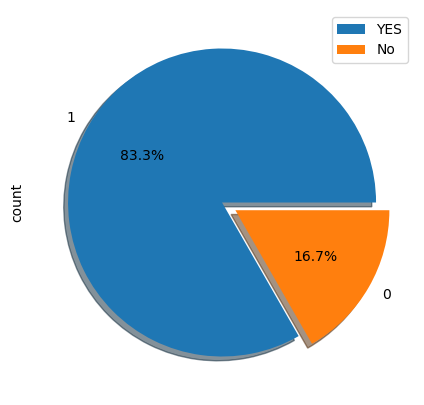

LabelEncoded
1    51386
0    10312
Name: count, dtype: int64


In [13]:
show_loan_distrib(df,'LabelEncoded')

## UnderSampling 1 - Random

In [14]:
from imblearn.under_sampling import RandomUnderSampler

x = ohe
y = df[label]

rus = RandomUnderSampler()

x_rus , y_rus = rus.fit_resample(x,y)
y_rus.value_counts() 

LabelEncoded
0               10312
1               10312
Name: count, dtype: int64

## OverSampling 1 - Random

In [15]:
from imblearn.over_sampling import RandomOverSampler

x = ohe
y = df[label]

ros = RandomOverSampler()

x_ros , y_ros = ros.fit_resample(x,y)
y_ros.value_counts() 

LabelEncoded
0               51386
1               51386
Name: count, dtype: int64

In [16]:
# pd.concat([x_ros,y_ros],axis=1)
# show_loan_distrib(pd.concat([x_ros,y_ros],axis=1),'LabelEncoded')

## OverSampling 2 - SMOTE

In [17]:
from imblearn.over_sampling import SMOTE

x = ohe
y = df[label]

smote = SMOTE()

x_smote , y_smote = smote.fit_resample(x,y)
y_smote.value_counts() 


LabelEncoded
0               51386
1               51386
Name: count, dtype: int64

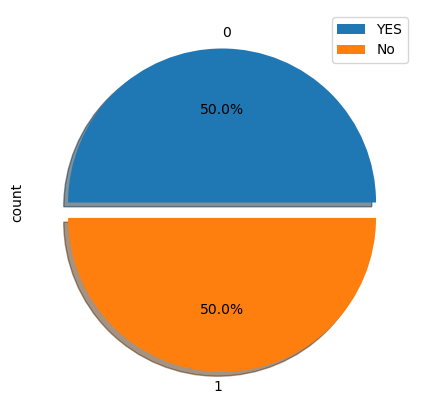

LabelEncoded
0    51386
1    51386
Name: count, dtype: int64


In [23]:
show_loan_distrib(pd.concat([x_smote,y_smote],axis=1),'LabelEncoded')

In [27]:
x_smote.duplicated().sum()

95412

## Mix of undersampling and oversampling

In [34]:
from imblearn.combine import SMOTEENN
